# Global Baseline Predictors and RMSE 
The goal of this project is to predict movie ratings with top critic ratings information web scraped Rotten Tomatoes. The predictions will first look at only raw averages across all training dataset users. Then, predictions will be modified to account for “bias” by normalizing across users and across items.


## Set-Up

The following packages will be used for math, web scraping, machine learning, visualization, and other basic functions.

In [2]:
#Basic
import pandas as pd
import numpy as np
import re

#Math
import math
from fractions import Fraction

#Webscraping
import urllib.request
from bs4 import BeautifulSoup
import json
import requests

#Machine Learning
from sklearn.model_selection import train_test_split

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Procedure
* Obtain and Clean Dataset: The dataset used will be web scraped from Rotten Tomatoes top critic reviews. To perform the web scraping, BeautifulSoup will be used to extract reviews from Rotten Tomatoes in json format.

* Create User-Item Matrix: Movies that have been reviewed by at least half of top critics will be included in the predictions.

* Test Train Split: Split the remaining reviews between a train and test dataset, using a test size of 20% and stratifying by movie.

* Evaluate Results: Determine the Root Mean Square Error of predictions to evaluate the accuracy of the model.

## Obtain and Clean Dataset

In [121]:
def scrape_rotten_tomatoes(reviewer_list, pages):
    # Create empty pandas dataframe
    reviews = pd.DataFrame(columns = ['author','movie','rating','tomatometer','date','review'])
    
    # Use BeautifulSoup to web scrape json string of movie reviews for each reviewer page
    for x in reviewer_list:
        page_range = range(1,pages+1) # Pagination
        for i in page_range:
            URL = "https://www.rottentomatoes.com/critic/" + x + "/movies?page=" + str(i) 
            page = urllib.request.urlopen(URL)
            soup = BeautifulSoup(page)
            json_tag = soup.select('head script[type="application/ld+json"]')[0]
            json_string = json_tag.string
            json_string = json.loads(str(json_string))

            # Pull relevant items from json string into a pandas dataframe
            for thing in json_string['@graph'][1]['itemListElement']:
                reviews = reviews.append({
                    'author': thing['item']['author']['name'],
                    'movie': thing['item']['itemReviewed']['name'],
                    'rating': thing['item']['reviewRating']['ratingValue'],
                    'tomatometer': thing['item']['reviewRating']['tomatometer'],
                    'date': thing['item']['datePublished'],
                    'review': thing['item']['reviewBody']
                }, ignore_index = True)
                
    # Remove reviews with empty ratings
    reviews = reviews[pd.notnull(reviews.rating)]
    
    # Convert any letter grades to fraction grades (rare scenario)
    def letter_to_frac(x):
        x = x.replace(r'A+',"100/100")
        x = x.replace(r'A-',"90/100")
        x = x.replace(r'A',"95/100")
        x = x.replace(r'B+',"85/100")
        x = x.replace(r'B-',"75/100")
        x = x.replace(r'B',"80/100")
        x = x.replace(r'C+',"65/100")
        x = x.replace(r'C-',"55/100")
        x = x.replace(r'C',"60/100")
        x = x.replace(r'D+',"45/100")
        x = x.replace(r'D-',"35/100")
        x = x.replace(r'D',"40/100")
        x = x.replace(r'F',"20/100")
        return x
    reviews.loc[:, 'rating'] = letter_to_frac(reviews.rating)
    
    # Convert fraction grades to floats
    reviews["rating"] = reviews["rating"].apply(lambda x: float(float(x.split( '/' )[0]) / float(x.split( '/' )[1])))
    
    # Return the resulting clean dataframe without duplicates (caused if there is excessive pagination)
    return reviews.drop_duplicates()

# Define a list of reviewers using format "firstname-lastname"
reviewer_list = ["christy-lemire",
           "pete-hammond",
           "matthew-lickona",
           "rafer-guzman",
           "peter-howell",
           "richard-roeper",
           "ty-burr",
           "james-berardinelli",
           "katie-walsh"]

# Provide the amount of pages to iterate through
pages = 5

# Run the web-scraping and clean-up function and assign to the dataframe 'reviews'
reviews = scrape_rotten_tomatoes(reviewer_list, pages)
reviews.head()

,author,movie,rating,tomatometer,date,review
0,Christy Lemire,The Secret Life of Pets 2,0.500,rotten,"Jun 6, 2019","Your kids will be sufficiently entertained, bu..."
1,Christy Lemire,Rocketman,0.625,fresh,"May 28, 2019",Egerton gives a performance with such thrills ...
2,Christy Lemire,Running with Beto,0.750,fresh,"May 28, 2019","Running With Beto is an intimate, thorough loo..."
3,Christy Lemire,The Sun Is Also a Star,0.625,fresh,"May 16, 2019",The leads are so lovely and the city is so shi...
4,Christy Lemire,The Hustle,0.500,rotten,"May 10, 2019","It's not terrible. It's not anything, really, ..."


## Create User-Item Matrix
### Filter Results

In [126]:
#Filter reviews to only show movies that at least half of reviewers have watched
movie_counts = reviews.groupby(by='movie').size()
movie_counts = pd.DataFrame(movie_counts).reset_index()
movie_counts.columns = ["movie","count_reviews"]
movie_list = list(movie_counts[movie_counts.count_reviews >= math.ceil(len(reviewer_list)/2)].movie)
print("There are " + str(len(movie_list)) + " movies that at least half of reviewers have watched.")

There are 125 movies that at least half of reviewers have watched.


29                          A Private War
31                          A Quiet Place
32                         A Simple Favor
33                         A Star Is Born
36                      A Wrinkle in Time
45                                Aladdin
48                    Alita: Battle Angel
62                          American Made
71                   Ant-Man and the Wasp
73                                Aquaman
85                      Avengers: Endgame
86                 Avengers: Infinity War
92             Bad Times at the El Royale
101                         Beautiful Boy
103                           Ben is Back
116                        BlacKkKlansman
121                     Blade Runner 2049
123                         Blindspotting
124                              Blockers
129                     Bohemian Rhapsody
131                             Book Club
132                             Booksmart
134                      Borg Vs. McEnroe
136                            Boy

In [127]:
#Take filtered reviews and transform into a user-item matrix
reviews = reviews[reviews.movie.isin(movie_list)][["author","movie","rating"]]

reviews_matrix = reviews.pivot_table(index = "movie", columns = "author", values = "rating")
reviews_matrix

author,Christy Lemire,James Berardinelli,Katie Walsh,Matthew Lickona,Pete Hammond,Peter Howell,Rafer Guzman,Richard Roeper,Ty Burr
movie,,,,,,,,,
A Private War,NaN,NaN,0.875,0.2,0.8,NaN,0.750,0.750,0.750
A Quiet Place,NaN,0.875,NaN,NaN,1.0,0.750,NaN,0.750,0.750
A Simple Favor,NaN,0.625,0.750,0.2,0.5,NaN,NaN,0.875,NaN
A Star Is Born,NaN,0.750,1.000,0.2,1.0,1.000,0.750,1.000,0.875
A Wrinkle in Time,NaN,NaN,0.625,NaN,0.5,NaN,0.500,0.500,0.625
Aladdin,NaN,0.500,0.750,0.2,NaN,NaN,0.375,0.750,0.625
Alita: Battle Angel,NaN,0.625,0.500,NaN,0.6,0.500,0.625,0.375,NaN
American Made,NaN,NaN,NaN,0.4,0.9,0.750,0.750,NaN,0.750
Ant-Man and the Wasp,0.750,0.500,0.750,0.2,0.7,0.750,0.625,0.750,0.875


### Visualize Reviews
#### Reviewer Harshness

Text(0.5, 1.0, 'Rating Overview by Reviewer')

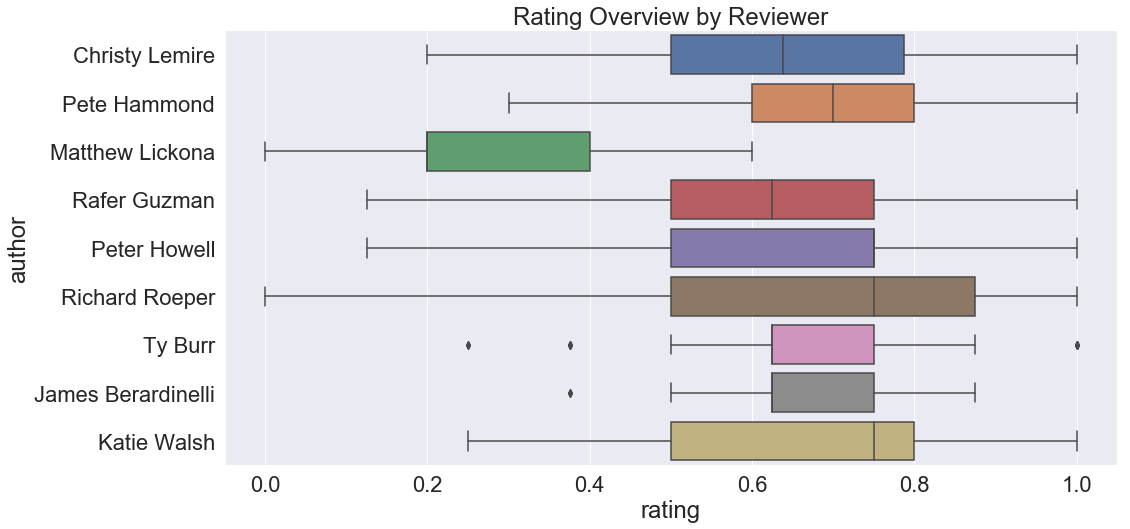

In [128]:
plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
sns.set(font_scale = 2)
sns.boxplot(x = "rating", y = "author", data = reviews).set_title('Rating Overview by Reviewer')

### Test-Train Split

In [129]:
X = reviews[["author","movie","rating"]]
y = reviews["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    stratify = X["movie"], 
                                                    random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(616, 3) (616,)
(155, 3) (155,)


### Raw Average Rating

In [130]:
train_mean = round(y_train.mean(),2)
print("The mean rating for all reviewers/all movies in the train set is " + str(train_mean) + ".")

The mean rating for all reviewers/all movies in the train set is 0.63.


### Root Mean Square Error

In [175]:
MSE_train = 0
for x in y_train:
    MSE_train = MSE_train + ((train_mean - x) ** 2)
RMSE_train = round(math.sqrt(MSE_train / len(y_train)),5)
print("The RMSE using the raw average as the predicted value for train data is " + str(RMSE_train) + ".")

MSE_test = 0
for x in y_test:
    MSE_test = MSE_test + ((train_mean - x) ** 2)
RMSE_test = round(math.sqrt(MSE_test / len(y_test)),5)
print("The RMSE using the raw average as the predicted value for test data is " + str(RMSE_test) + ".")

The RMSE using the raw average as the predicted value for train data is 0.218.
The RMSE using the raw average as the predicted value for test data is 0.21502.


29.27387499999995

### Bias Calculations

In [138]:
author_bias = X_train.groupby(by="author").agg("mean").reset_index()
author_bias = author_bias.assign(author_bias = lambda author_bias: author_bias.rating - train_mean)
movie_bias = X_train.groupby(by="movie").agg("mean").reset_index()
movie_bias = movie_bias.assign(movie_bias = lambda movie_bias: movie_bias.rating - train_mean)

In [167]:
#Add author_bias and movie_bias to the train set
X_train_bias = pd.merge(X_train, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_train_bias = pd.merge(X_train_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_train_bias = X_train_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the train set
X_train_bias = X_train_bias.assign(
    predictor = lambda X_train_bias: (train_mean + X_train_bias.author_bias + X_train_bias.movie_bias))

#Add author_bias and movie_bias to the test set
X_test_bias = pd.merge(X_test, author_bias[["author","author_bias"]], how = 'left', on = "author")
X_test_bias = pd.merge(X_test_bias, movie_bias[["movie","movie_bias"]], how = 'left', on = "movie")
X_test_bias = X_test_bias[["author","movie","rating","author_bias","movie_bias"]]

#Add baseline predictor to the test set
X_test_bias = X_test_bias.assign(
    predictor = lambda X_test_bias: (train_mean + X_test_bias.author_bias + X_test_bias.movie_bias))

### RMSE for Baseline Predictors

In [189]:
X_train_bias.head()

MSE_train_bias = 0
for i in range(len(X_train_bias.predictor)):
    MSE_train_bias = MSE_train_bias + ((X_train_bias.rating[i] - X_train_bias.predictor[i]) ** 2)
RMSE_train_bias = round(math.sqrt(MSE_train_bias / len(X_train_bias)),5)
print("The RMSE using bias in the predicted value calculations for train data is " + str(RMSE_train_bias) + ".")

The RMSE using bias in the predicted value calculations for train data is 0.12602.


In [190]:
X_test_bias.head()

MSE_test_bias = 0
for i in range(len(X_test_bias.predictor)):
    MSE_test_bias = MSE_test_bias + ((X_test_bias.rating[i] - X_test_bias.predictor[i]) ** 2)
RMSE_test_bias = round(math.sqrt(MSE_test_bias / len(X_test_bias)),5)
print("The RMSE using bias in the predicted value calculations for test data is " + str(RMSE_test_bias) + ".")

The RMSE using bias in the predicted value calculations for test data is 0.14061.


### Summary

### Interactive